In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.stats import pearsonr
from scipy.spatial import distance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.signal as signal
from causality import *
from scipy import stats
from scipy.stats import norm
import os
import warnings
warnings.filterwarnings("ignore")

from matplotlib import rc

# 设置全局字体为Times New Roman
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

# Case 1

In [2]:
def func_1(x, y, z, sigma, rho, beta, noise):
    x_ = (sigma*y-rho*z)*(y-beta*z) + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_1(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"Sampling Stamp":range(1,len(x)+1),"X":x,"Y":y,"Z":z})

Text(0.5, 0, 'timestep')

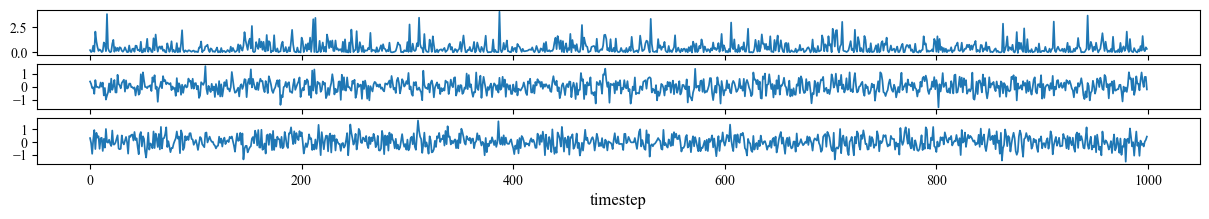

In [3]:
plt.figure(figsize=(15,2))
max_t = 1000
plt.subplot(3, 1, 1)
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.subplot(3, 1, 2)
plt.plot(y[:max_t], linewidth=1.25, label='Y')
plt.subplot(3, 1, 3)
plt.plot(z[:max_t], linewidth=1.25, label='Z')
plt.xlabel('timestep', size=12)
# plt.ylabel('value of X or Y or Z', size=12)
# plt.legend(prop={'size': 16})

In [4]:
Case_name = "case1"
if not os.path.exists(Case_name):
    os.makedirs(Case_name)

In [5]:
df.to_csv(os.path.join(Case_name, Case_name+".csv"), index=False)

In [2]:
Case_name = "case1"
df = pd.read_csv(os.path.join(Case_name, Case_name+".csv"))

In [3]:
x = df.X.values
y = df.Y.values
z = df.Z.values

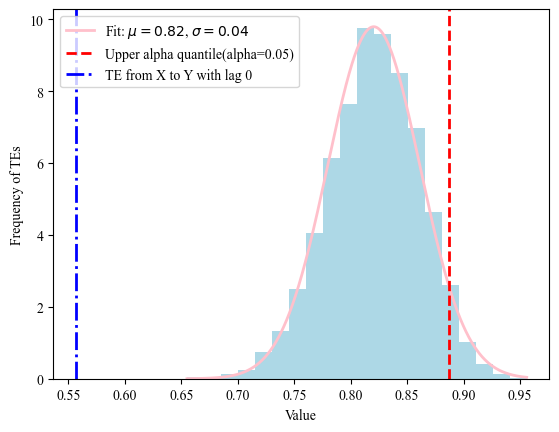

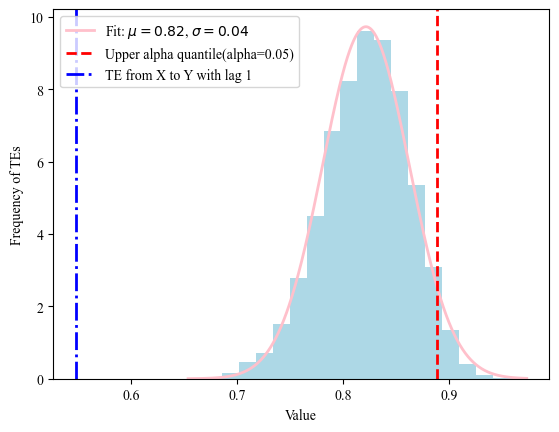

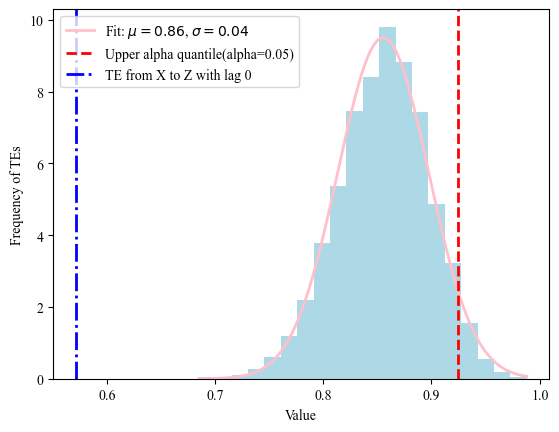

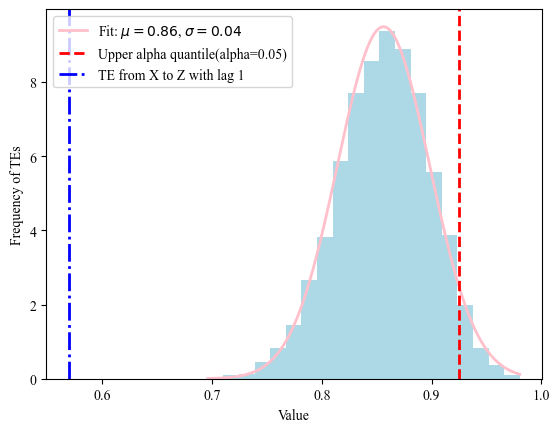

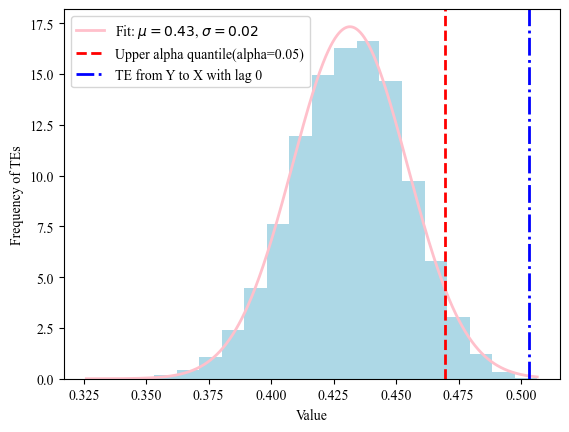

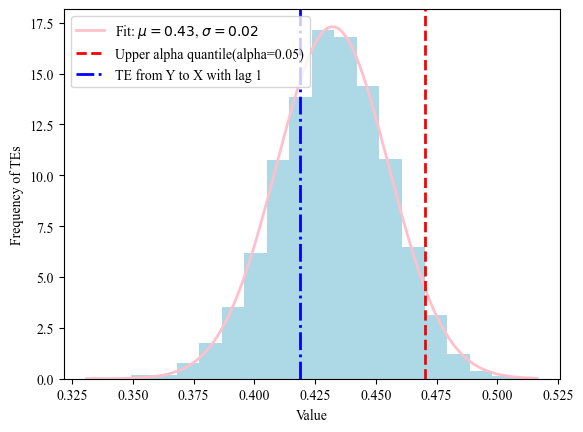

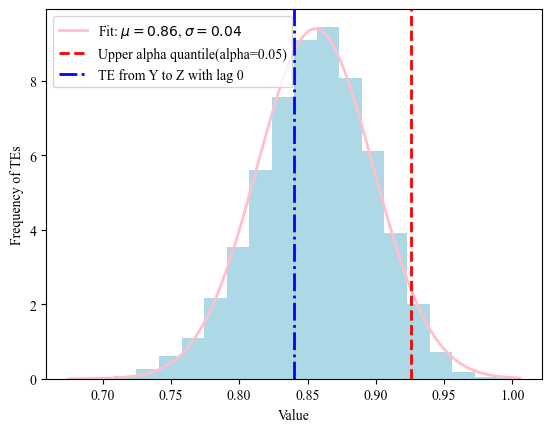

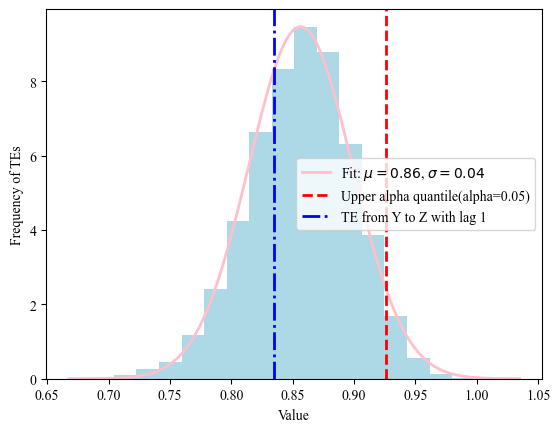

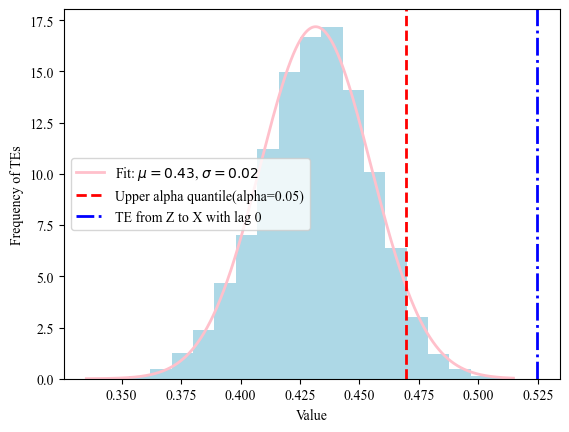

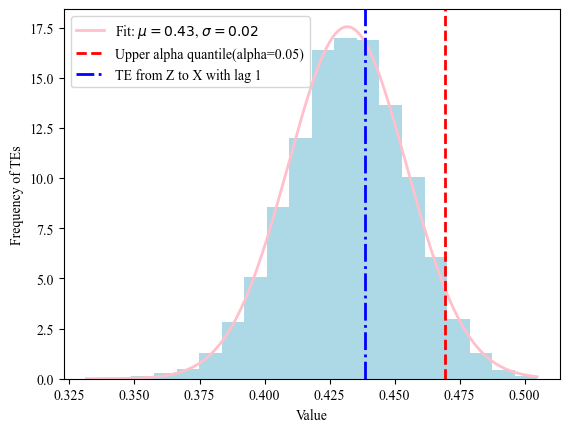

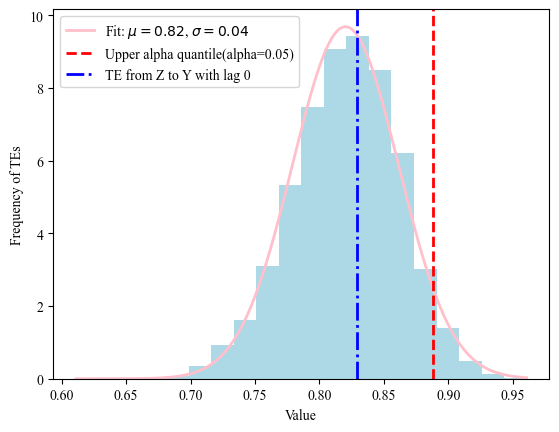

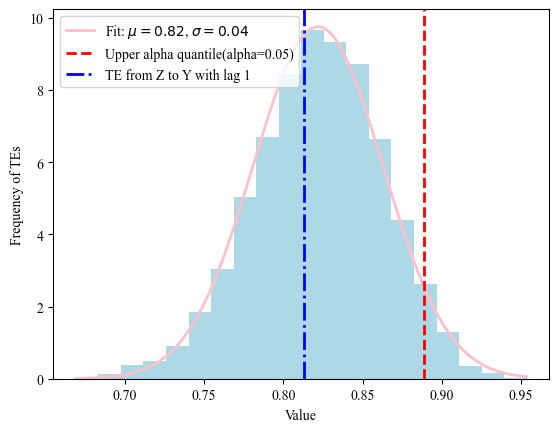

In [11]:
te = TransferEntropy()
res = None
for Cause_name, Result_name in [("x","y"), ("x","z"), ("y","x"), ("y","z"), ("z","x"),  ("z","y")]:  # 
    for lag in range(2):

        Cause = eval(Cause_name)
        Result = eval(Result_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.te_xy_with_lag_sigma(Result, wgn, lag_x=lag))
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        TExy = te.te_xy_with_lag(Result, Cause, lag_x=lag)["TE(X->Y)"]
        Pxy = round(stats.norm.sf((TExy - mean) / std), 4)

        # 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(TExy, color='blue', linestyle='-.', linewidth=2, label=f'TE from {str(Cause_name).upper()} to {str(Result_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of TEs')
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(Case_name, Case_name+f'_TE{str(Cause_name)}{str(Result_name)}_lag{str(lag)}.png'), dpi=600, bbox_inches='tight')
        raw = {"Cause": Cause_name, "Result": Result_name, "TE": TExy, "alpha_value": alpha_value, "p": Pxy, "alpha": alpha_percentile, "lag": lag+1}
        if res is None:
            res = pd.DataFrame(raw, index=[1])
        else:
            res = res.append(raw, ignore_index=True)
res.to_csv(os.path.join(Case_name, Case_name+"_te_res.csv"), index=False)

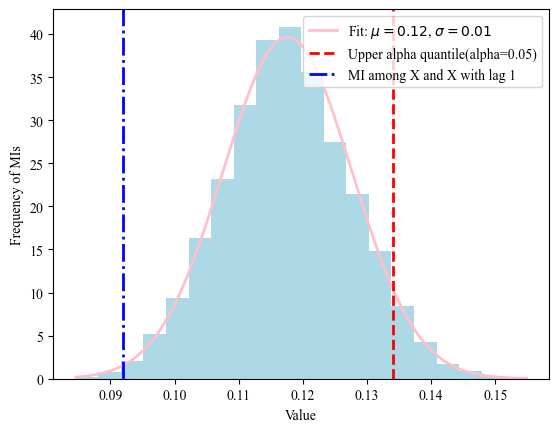

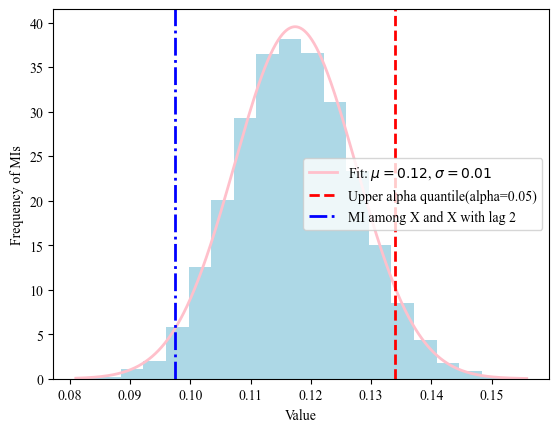

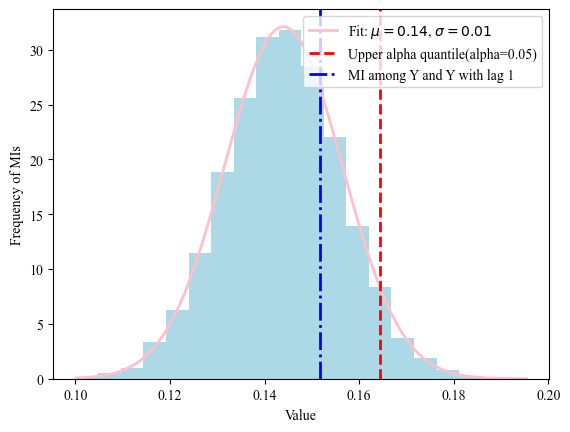

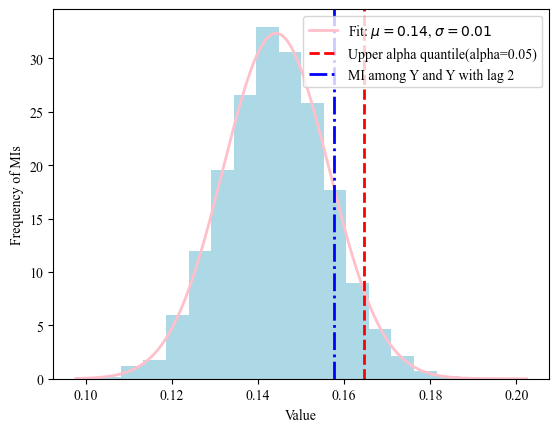

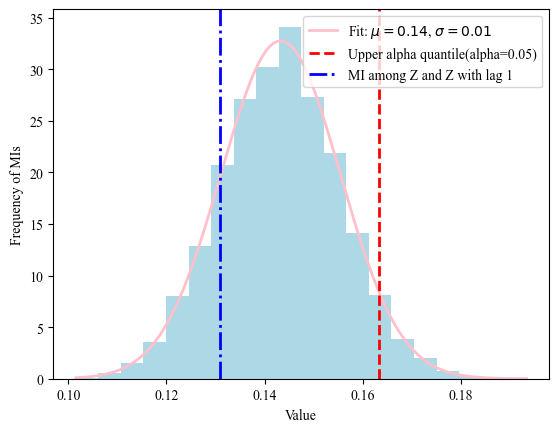

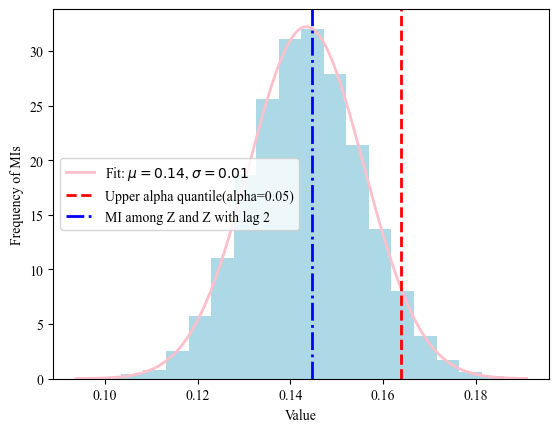

In [5]:
te = TransferEntropy()
res = None
for Cause_name, Result_name in [("x","x"), ("y","y"), ("z","z")]:  # 
    for lag in range(1,3):

        Cause = eval(Cause_name)
        Result = eval(Result_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.mi_with_lag(Result, wgn, lag_x=lag)["MI(X<->Y)"])
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        MIxy = te.mi_with_lag(Result, Cause, lag_x=lag)["MI(X<->Y)"]
        Pxy = round(stats.norm.sf((MIxy - mean) / std), 4)
        
        # 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(MIxy, color='blue', linestyle='-.', linewidth=2, label=f'MI among {str(Cause_name).upper()} and {str(Result_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of MIs')
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(Case_name, Case_name+f'_MI{str(Cause_name)}{str(Result_name)}_lag{str(lag)}.png'), dpi=600, bbox_inches='tight')
        

        raw = {"Cause": Cause_name, "Result": Result_name, "MIxy": MIxy, "alpha_value": alpha_value, "p": Pxy, "alpha": alpha_percentile, "lag": lag}
        if res is None:
            res = pd.DataFrame(raw, index=[1])
        else:
            res = res.append(raw, ignore_index=True)
res.to_csv(os.path.join(Case_name, Case_name+"_mi_res.csv"), index=False)

In [162]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x_ = np.array([[x1, x2] for x1, x2 in zip(y[:-301], z[:-301])])  # 将 X1 和 X2 合并为一个特征矩阵
poly = PolynomialFeatures(degree=4)  # 设置多项式的最高阶数
X_poly = poly.fit_transform(x_)
model = LinearRegression()
model.fit(X_poly, x[1:701])
coefficients = model.coef_
intercept = model.intercept_
coefficients[::-1], intercept

(array([ 3.23542597e-03,  3.24833271e-03, -3.16342605e-03, -4.83653557e-03,
         2.06662513e-03, -3.39628092e-03, -6.82124063e-03, -2.91911384e-03,
         7.67007382e-04,  9.31281570e-01, -1.89633641e+00,  8.99750522e-01,
         2.39967249e-03,  1.45345154e-03,  0.00000000e+00]),
 0.00019310348828383006)

In [166]:
x_ = np.array([[x1, x2] for x1, x2 in zip(y[-301:-21], z[-301:-21])])
X_poly = poly.fit_transform(x_)
data_fit_x_supervise = model.predict(X_poly)

In [256]:
noise = 0.5*stats.norm.rvs(size=(20,2))
y = noise[:,0]
z = noise[:,1]
x_ = np.array([[x1, x2] for x1, x2 in zip(y, z)])
X_poly = poly.fit_transform(x_)
data_fit_x_unsupervise = model.predict(X_poly)

In [258]:
data_fit_x = np.hstack((data_fit_x_supervise, data_fit_x_unsupervise))

In [259]:
FitData = pd.DataFrame({"Sampling Stamp": range(1,301),
                        "Ground Truth X": x[701:],
                        "Polynomial Fit X": data_fit_x})
FitData.to_csv(os.path.join(Case_name, Case_name+"_fit.csv"), index=False)

In [59]:
x_ = np.array([[x1, x2] for x1, x2 in zip(y[-301:-1], z[-301:-1])])
X_poly = poly.fit_transform(x_)
data_fit = model.predict(X_poly)
pd.DataFrame({"Sampling Stamp":range(1,len(x[701:])+1),"Ground Truth":x[701:], "Polynomial Fit": data_fit}).to_csv(os.path.join(Case_name, Case_name+"_fit.csv"), index=False)

# HenonMap

In [76]:
noise = stats.norm.rvs(size=(2000,3))
def HenonMap(x, y, noise, alpha=1.4, beta=0.3):
    x_ = 1 - alpha * x * x + y + 0.0001*noise[0]
    y_ = beta * x + 0.0001*noise[1]
    return x_, y_
x0 = 0.0  # initial val
y0 = 0.0  # initial val
t = 1000  # time steps

x = [x0]
y = [y0]
for i in range(t):
    x_, y_  = HenonMap(x[-1], y[-1], noise[i])
    x.append(x_)
    y.append(y_)
df = pd.DataFrame({"Sampling Stamp":range(1,len(x)+1),"X":x,"Y":y})

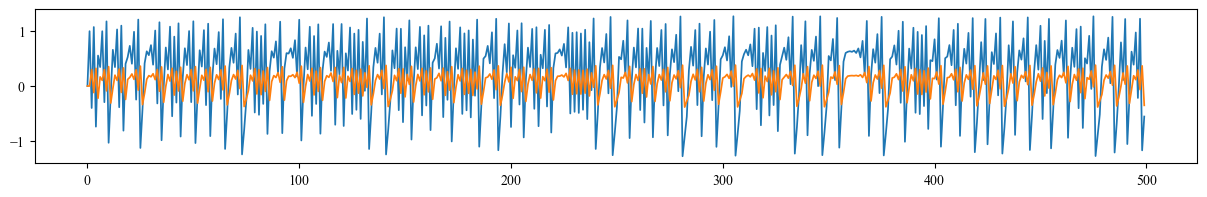

In [77]:
plt.figure(figsize=(15,2))
max_t = 500
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.plot(y[:max_t], linewidth=1.25, label='Y')

In [78]:
Case_name = "HenonMap"
if not os.path.exists(Case_name):
    os.makedirs(Case_name)

In [79]:
df.to_csv(os.path.join(Case_name, Case_name+".csv"), index=False)

In [2]:
Case_name = "HenonMap"
df = pd.read_csv(os.path.join(Case_name, Case_name+".csv"))

In [3]:
x = df.X.values
y = df.Y.values

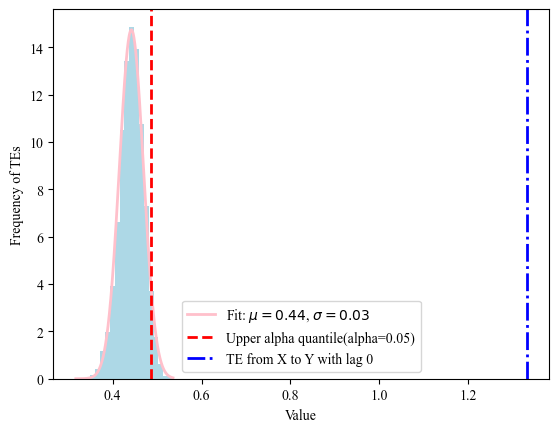

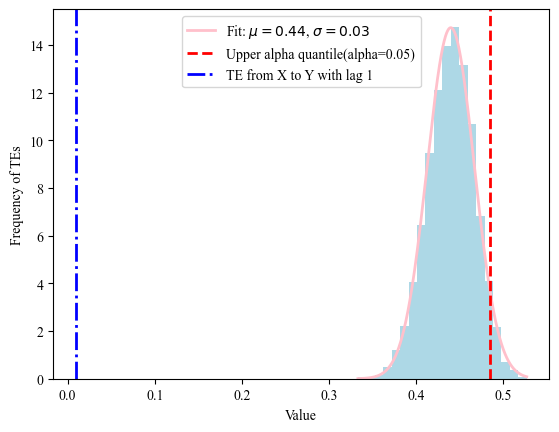

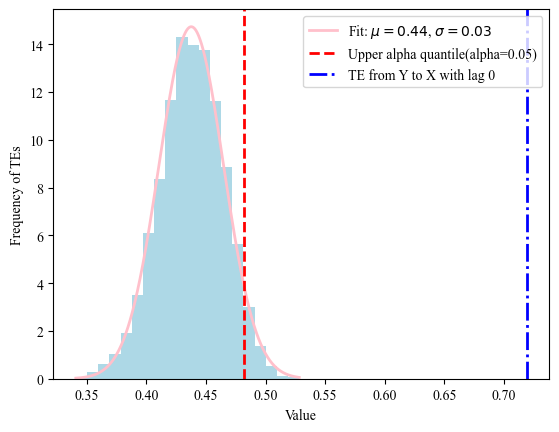

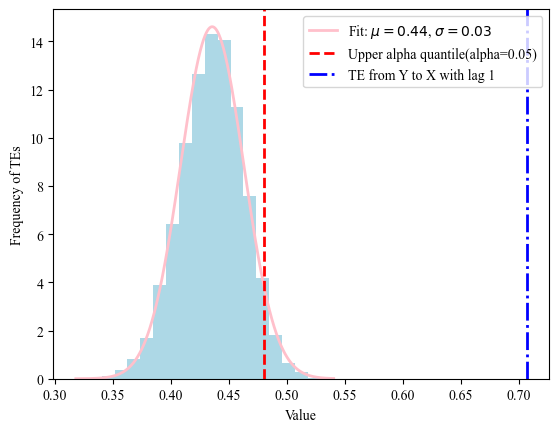

In [11]:
te = TransferEntropy()
res = None
for Cause_name, Result_name in [("x","y"), ("y","x")]:  # 
    for lag in range(2):

        Cause = eval(Cause_name)
        Result = eval(Result_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.te_xy_with_lag_sigma(Result, wgn, lag_x=lag))
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        TExy = te.te_xy_with_lag(Result, Cause, lag_x=lag)["TE(X->Y)"]
        Pxy = round(stats.norm.sf((TExy - mean) / std), 4)

        # 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(TExy, color='blue', linestyle='-.', linewidth=2, label=f'TE from {str(Cause_name).upper()} to {str(Result_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of TEs')
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(Case_name, Case_name+f'_TE{str(Cause_name)}{str(Result_name)}_lag{str(lag)}.png'), dpi=600, bbox_inches='tight')
        raw = {"Cause": Cause_name, "Result": Result_name, "TE": TExy, "alpha_value": alpha_value, "p": Pxy, "alpha": alpha_percentile, "lag": lag+1}
        if res is None:
            res = pd.DataFrame(raw, index=[1])
        else:
            res = res.append(raw, ignore_index=True)
res.to_csv(os.path.join(Case_name, Case_name+"_res.csv"), index=False)

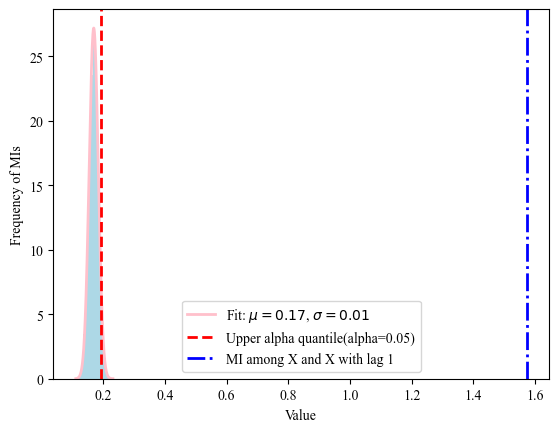

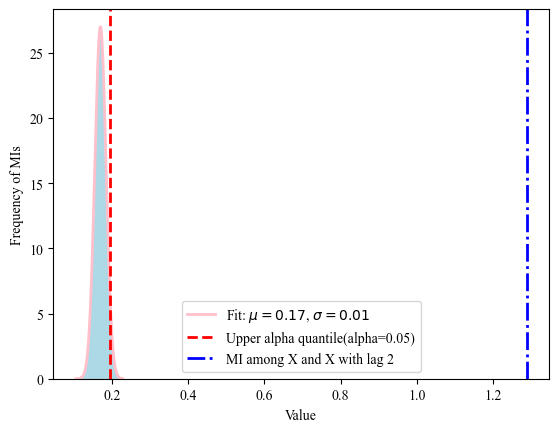

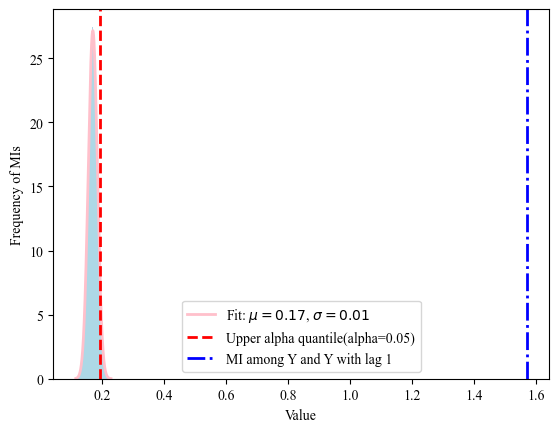

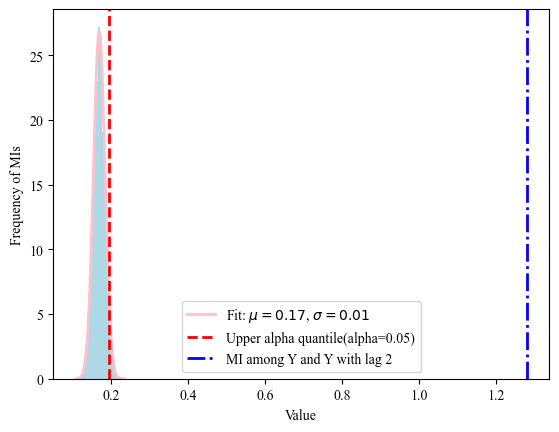

In [4]:
te = TransferEntropy()
res = None
for Cause_name, Result_name in [("x","x"), ("y","y")]:  # 
    for lag in range(1,3):

        Cause = eval(Cause_name)
        Result = eval(Result_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.mi_with_lag(Result, wgn, lag_x=lag)["MI(X<->Y)"])
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        MIxy = te.mi_with_lag(Result, Cause, lag_x=lag)["MI(X<->Y)"]
        Pxy = round(stats.norm.sf((MIxy - mean) / std), 4)
# 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(MIxy, color='blue', linestyle='-.', linewidth=2, label=f'MI among {str(Cause_name).upper()} and {str(Result_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of MIs')
        plt.legend()

        # Save the plot
        plt.savefig(os.path.join(Case_name, Case_name+f'_MI{str(Cause_name)}{str(Result_name)}_lag{str(lag)}.png'), dpi=600, bbox_inches='tight')
        
        raw = {"Cause": Cause_name, "Result": Result_name, "MIxy": MIxy, "alpha_value": alpha_value, "p": Pxy, "alpha": alpha_percentile, "lag": lag}
        if res is None:
            res = pd.DataFrame(raw, index=[1])
        else:
            res = res.append(raw, ignore_index=True)
res.to_csv(os.path.join(Case_name, Case_name+"_mi_res.csv"), index=False)

In [8]:
te = TransferEntropy()
te.cmi_with_lag(x, x, x, lag_x=2, lag_z=1)

{'CMI(X<->Y|Z)': 0.716,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.765,
 'CriticalValue(0.05)': 1.7472,
 'CriticalValue(0.10)': 1.7377}

In [6]:
te = TransferEntropy()
Cause = x
noise_mean = np.mean(Cause)
noise_std_dev = np.std(Cause)
CMIs = []
for i in range(10000):    
    wgn = stats.norm.rvs(size=np.array(Cause).shape)
    CMIs.append(te.cmi_with_lag_sigma(x, x, wgn, lag_x=2, lag_z=1))
CMIs = np.array(CMIs)
# Calculate alpha percentile values
mean = np.array(CMIs).mean()
std = np.array(CMIs).std()
alpha_percentile = 0.05
alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

CMIxyz = 0.716
Pxy = round(stats.norm.sf((CMIxyz - mean) / std), 4)
# 生成拟合曲线数据
x_ = np.linspace(min(CMIs), max(CMIs), 1000)
y_ = norm.pdf(x_, mean, std)

# 绘制拟合曲线
plt.figure()
plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

# Create a histogram
plt.hist(CMIs, bins=20, density=True, color="lightblue")
plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Upper alpha quantile(alpha={alpha_percentile})')
plt.axvline(CMIxyz, color='blue', linestyle='-.', linewidth=2,
            label=f'MI among X and X with lag {2} under X with lag {1} ')
#         plt.title('Histogram of TEs')
plt.xlabel('Value')
plt.ylabel('Frequency of CMIs')
plt.legend()

# Save the plot
plt.savefig(os.path.join(Case_name, Case_name+f'_CMIx_x2_x1.png'), dpi=600, bbox_inches='tight')


In [9]:
te.cmi_with_lag(y, y, y, lag_x=2, lag_z=1)

{'CMI(X<->Y|Z)': 0.7165,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.7631,
 'CriticalValue(0.05)': 1.7454,
 'CriticalValue(0.10)': 1.736}

In [4]:
te = TransferEntropy()
Cause = y
noise_mean = np.mean(Cause)
noise_std_dev = np.std(Cause)
CMIs = []
for i in range(10000):    
    wgn = stats.norm.rvs(size=np.array(Cause).shape)
    CMIs.append(te.cmi_with_lag_sigma(y, y, wgn, lag_x=2, lag_z=1))
CMIs = np.array(CMIs)
# Calculate alpha percentile values
mean = np.array(CMIs).mean()
std = np.array(CMIs).std()
alpha_percentile = 0.05
alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

CMIxyz = 0.7165
Pxy = round(stats.norm.sf((CMIxyz - mean) / std), 4)
# 生成拟合曲线数据
x_ = np.linspace(min(CMIs), max(CMIs), 1000)
y_ = norm.pdf(x_, mean, std)

# 绘制拟合曲线
plt.figure()
plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

# Create a histogram
plt.hist(CMIs, bins=20, density=True, color="lightblue")
plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Upper alpha quantile(alpha={alpha_percentile})')
plt.axvline(CMIxyz, color='blue', linestyle='-.', linewidth=2,
            label=f'MI among Y and Y with lag {2} under Y with lag {1} ')
#         plt.title('Histogram of TEs')
plt.xlabel('Value')
plt.ylabel('Frequency of CMIs')
plt.legend()

# Save the plot
plt.savefig(os.path.join(Case_name, Case_name+f'_CMIy_y2_y1.png'), dpi=600, bbox_inches='tight')


In [10]:
te.cmi_with_lag(x, y, y, lag_x=2, lag_z=1)

{'CMI(X<->Y|Z)': 0.7765,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.6763,
 'CriticalValue(0.05)': 1.6557,
 'CriticalValue(0.10)': 1.6446}

In [4]:
te = TransferEntropy()
Cause = y
noise_mean = np.mean(Cause)
noise_std_dev = np.std(Cause)
CMIs = []
for i in range(10000):    
    wgn = stats.norm.rvs(size=np.array(Cause).shape)
    CMIs.append(te.cmi_with_lag_sigma(x, y, wgn, lag_x=2, lag_z=1))
CMIs = np.array(CMIs)
# Calculate alpha percentile values
mean = np.array(CMIs).mean()
std = np.array(CMIs).std()
alpha_percentile = 0.05
alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

CMIxyz = 0.7765
Pxy = round(stats.norm.sf((CMIxyz - mean) / std), 4)
# 生成拟合曲线数据
x_ = np.linspace(min(CMIs), max(CMIs), 1000)
y_ = norm.pdf(x_, mean, std)

# 绘制拟合曲线
plt.figure()
plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

# Create a histogram
plt.hist(CMIs, bins=20, density=True, color="lightblue")
plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Upper alpha quantile(alpha={alpha_percentile})')
plt.axvline(CMIxyz, color='blue', linestyle='-.', linewidth=2,
            label=f'MI among X and Y with lag {2} under Y with lag {1} ')
#         plt.title('Histogram of TEs')
plt.xlabel('Value')
plt.ylabel('Frequency of CMIs')
plt.legend()

# Save the plot
plt.savefig(os.path.join(Case_name, Case_name+f'_CMIx_y2_y1.png'), dpi=600, bbox_inches='tight')


In [114]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x_ = np.array([[x1, x2] for x1, x2 in zip(x[:-301], y[:-301])])  # 将 X1 和 X2 合并为一个特征矩阵
poly = PolynomialFeatures(degree=4)  # 设置多项式的最高阶数
X_poly = poly.fit_transform(x_)
model_x = LinearRegression()
model_x.fit(X_poly, x[1:701])
coefficients = model_x.coef_
intercept = model_x.intercept_
coefficients, intercept

(array([ 0.00000000e+00, -2.11157158e-04,  1.00008999e+00, -1.39982483e+00,
         7.37063784e-05, -3.49847312e-03, -6.49557833e-05, -1.40602341e-04,
         4.16062703e-03, -4.53246574e-04,  1.75124624e-05,  1.46442230e-04,
        -3.09127852e-04, -1.55644101e-03,  3.11988360e-02]),
 1.0000771629986835)

In [115]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x_ = np.array([[x1, x2] for x1, x2 in zip(x[:-301], y[:-301])])  # 将 X1 和 X2 合并为一个特征矩阵
poly = PolynomialFeatures(degree=4)  # 设置多项式的最高阶数
X_poly = poly.fit_transform(x_)
model_y = LinearRegression()
model_y.fit(X_poly, y[1:701])
coefficients = model_y.coef_
intercept = model_y.intercept_
coefficients, intercept

(array([ 0.00000000e+00,  3.00201548e-01, -7.55656362e-05, -1.92272294e-04,
        -2.34424530e-04,  2.13651376e-03,  9.93181334e-05,  2.90996430e-04,
        -3.16417624e-03,  1.08052189e-03, -3.94927525e-05, -2.67833980e-05,
         1.54136424e-03,  4.16099694e-03, -1.72705704e-02]),
 -6.837218965072278e-05)

In [149]:
x_ = np.array([[x1, x2] for x1, x2 in zip(x[-301:-21], y[-301:-21])])
X_poly = poly.fit_transform(x_)
data_fit_x_supervise = model_x.predict(X_poly)

In [150]:
x_ = np.array([[x1, x2] for x1, x2 in zip(x[-301:-21], y[-301:-21])])
X_poly = poly.fit_transform(x_)
data_fit_y_supervise = model_y.predict(X_poly)

In [151]:
data_fit_x_unsupervise = list(x[-35:-20])
data_fit_y_unsupervise = list(y[-35:-20])
for i in range(20):
    x_ = np.array([[x1, x2] for x1, x2 in zip(data_fit_x_unsupervise[-15:], data_fit_y_unsupervise[-15:])])
    X_poly = poly.fit_transform(x_)
    data_fit_x_unsupervise.append(model_x.predict(X_poly)[-1])
    data_fit_y_unsupervise.append(model_y.predict(X_poly)[-1])
    
data_fit_x_unsupervise = np.array(data_fit_x_unsupervise[15:])
data_fit_y_unsupervise = np.array(data_fit_y_unsupervise[15:])

In [152]:
data_fit_x = np.hstack((data_fit_x_supervise, data_fit_x_unsupervise))
data_fit_y = np.hstack((data_fit_y_supervise, data_fit_y_unsupervise))

In [159]:
FitData = pd.DataFrame({"Sampling Stamp": range(1,301),
                        "Ground Truth X": x[701:],
                        "Polynomial Fit X": data_fit_x,
                        "Ground Truth Y": y[701:],
                        "Polynomial Fit Y": data_fit_y,})
FitData.to_csv(os.path.join(Case_name, Case_name+"_fit.csv"), index=False)